In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [3]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory
from anomaly.utils import specobjid_to_idx
from astroExplain.spectra.notebook import interpret, explain_reconstruction_score

meta = MetaData()
%matplotlib inline

In [4]:
# config
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"

In [5]:
# load data
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
model = AutoEncoder(reload=True, reload_from=model_directory)

## Explore common anomalies of different scores

In [6]:
intersection_directory = f"{explanations_directory}/intersections"
specobjid_common_anomalies = np.load(f"{intersection_directory}/specobjid_lp_intersection_1000.npy")
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
idx_id = np.load(f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy")

### generate explanation in notebook

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=407595591024011264&apid=


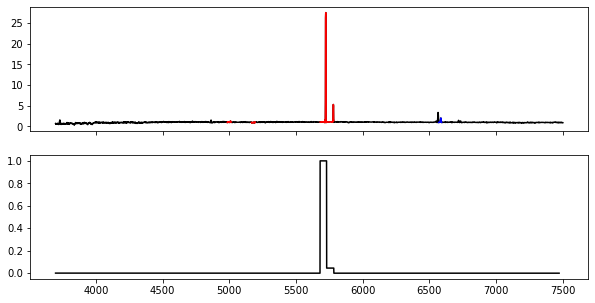

In [7]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "kmeans",
    "number_segments": 128,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":0.05,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel100"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-4]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=4, negative=1)
print(meta.get_sky_server_url(specobjid))

save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
FileDirectory.check_directory(save_to, exit_program=False)
fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
    pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=969534273977608192&apid=


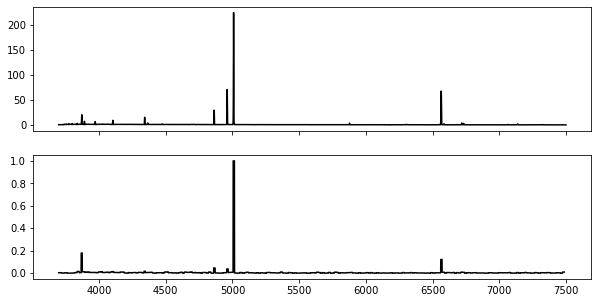

In [10]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "kmeans",
    "number_segments": 256,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.7,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": False,
    "kernel_size": 3,
    "sigma": 0
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel100"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-12]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0)
print(meta.get_sky_server_url(specobjid))

# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2501881598136313856&apid=


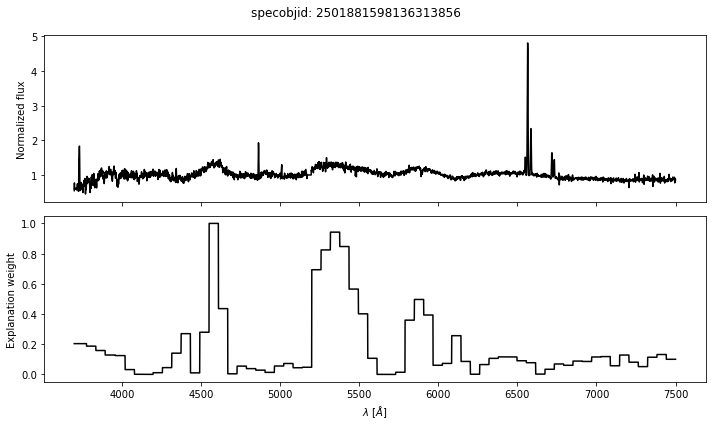

In [30]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-7]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=(10, 6))
print(meta.get_sky_server_url(specobjid))
fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()
# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2664004586678806528&apid=


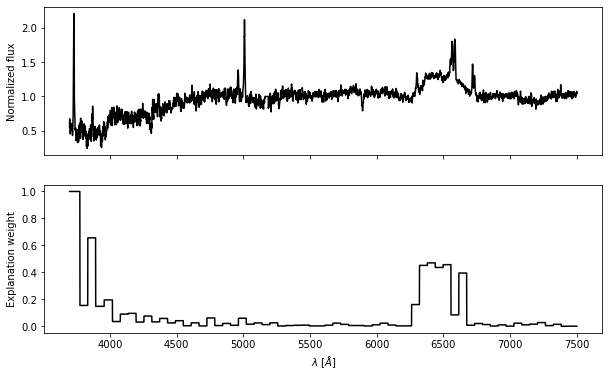

In [45]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.8,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-98]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=(10, 6))
print(meta.get_sky_server_url(specobjid))

# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=352578222723983360&apid=


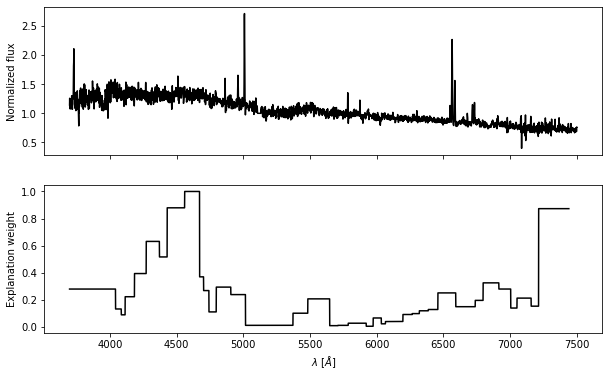

In [59]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "kmeans",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-79]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=(10, 6))
print(meta.get_sky_server_url(specobjid))

# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1461501691693131776&apid=


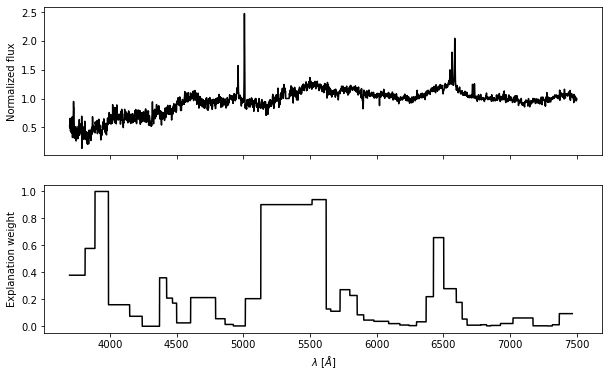

In [63]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "kmeans",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.8,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-74]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=(10, 6))
print(meta.get_sky_server_url(specobjid))

# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1945689783355336704&apid=


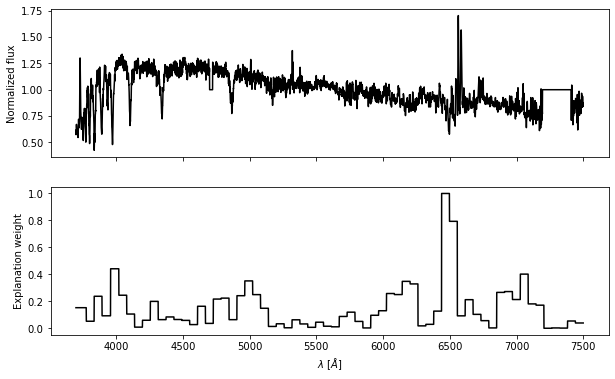

In [81]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
# if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.5,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-65]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=(10, 6))
print(meta.get_sky_server_url(specobjid))

# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=863651577993390080&apid=


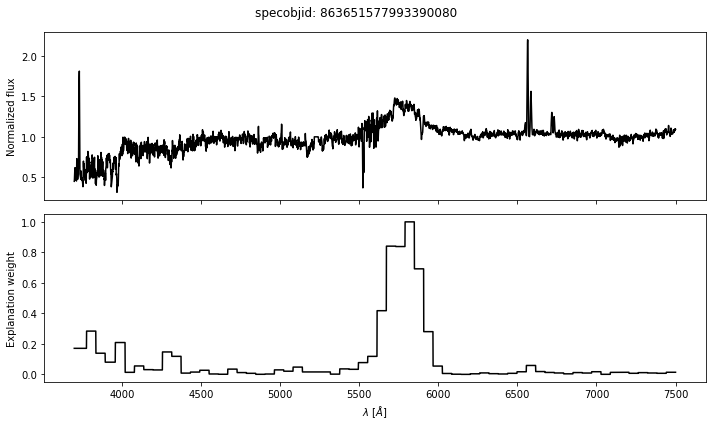

In [73]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.5,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-61]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=(10, 6))
print(meta.get_sky_server_url(specobjid))
fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()
# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1780176998165932032&apid=


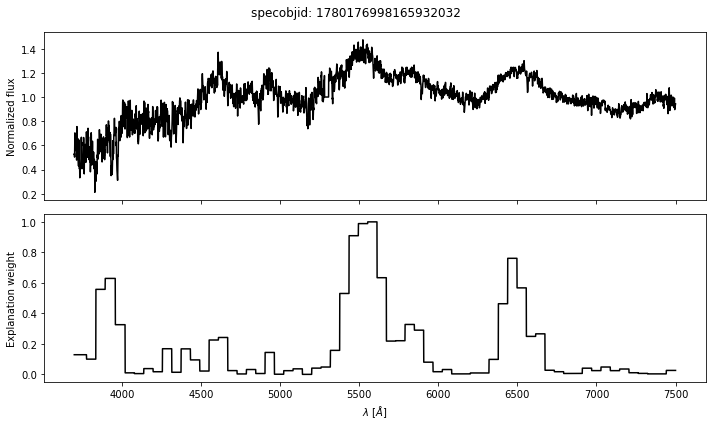

In [74]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.5,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-14]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=(10, 6))
print(meta.get_sky_server_url(specobjid))
fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()
# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=393105946882107392&apid=


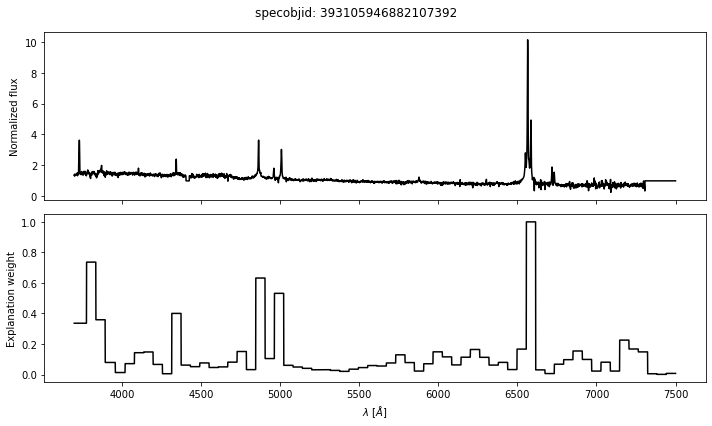

In [83]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
# if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.8,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-9]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=(10, 6))
print(meta.get_sky_server_url(specobjid))
fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()
# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=637325355518027776&apid=


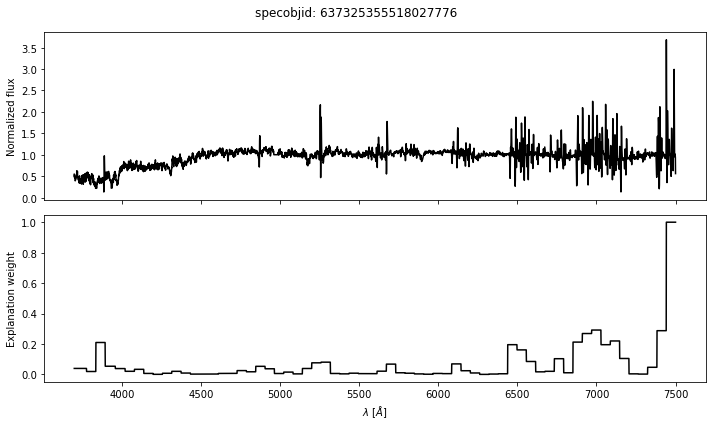

In [84]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
# if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.8,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-6]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=(10, 6))
print(meta.get_sky_server_url(specobjid))
fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()
# save_to = f"/home/edgar/gdrive/ai/presentations/iml_cata/explantions"
# FileDirectory.check_directory(save_to, exit_program=False)
# fudge_method = f"{lime_config['segmentation']}_{lime_config['number_segments']}_{fudge_config['kind_of_fudge']}"

# with open(f"{save_to}/{specobjid}_{anomaly_from_score}_{fudge_method}.pkl", "wb") as file:
#     pickle.dump(explanation, file)